### Imports, globals and shared funcitons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from scipy.stats import t as student_t
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Core defaults
SEED = 42
rng_global = np.random.default_rng(SEED)
N = 1000
T = 10_000
discard = 1000
K0 = 100.0
r_min, r_max = 3.9, 4.0
BINS_DEFAULT = 15
LAG_K_DEFAULT = 2

# Modulators
def K_sinusoid(n, K0=100.0, A=25.0, omega=2*np.pi/2000):
    return K0 + A * np.sin(omega * n)

def K_logistic(n, K0=100.0, A=25.0, k=0.002, n0=5000):
    return K0 + A / (1.0 + np.exp(-k * (n - n0)))

def K_invlogistic(n, K0=100.0, A=25.0, k=0.002, n0=5000):
    return K0 + A / (1.0 + np.exp(+k * (n - n0)))

# Dynamics
def logistic_step(x, r, K):
    return r * x * (1 - x / K)

# Simulators
def simulate_full_population(mod_fn, N=N, T=T, K0=K0, r_min=r_min, r_max=r_max, seed=None):
    """
    Returns:
      X_all: (N, T) states
      K_series: (T,) carrying capacity values
    """
    rng = np.random.default_rng(seed)
    x = np.full(N, 0.1)
    r = rng.uniform(r_min, r_max, N)

    X_all = np.zeros((N, T))
    K_series = np.zeros(T)

    for n in range(T):
        K_n = mod_fn(n)
        K_series[n] = K_n
        x = logistic_step(x, r, K_n)
        x = np.clip(x, 0, 2 * K0)
        X_all[:, n] = x

    return X_all, K_series

def simulate_mean_and_unit(mod_fn, N=N, T=T, discard=discard, K0=K0,
                           r_min=r_min, r_max=r_max, seed=None):
    """
    Returns:
      M: (T - discard,) mean field
      x0: (T - discard,) representative unit
      clip_frac: (T - discard,) fraction of units at constant ceiling 2*K0
    """
    rng = np.random.default_rng(seed)
    x = np.full(N, 0.1)
    r = rng.uniform(r_min, r_max, N)

    M, x0, clip_frac = [], [], []
    for n in range(T):
        K_n = mod_fn(n)
        x = logistic_step(x, r, K_n)
        x = np.clip(x, 0, 2 * K0)
        if n >= discard:
            M.append(np.mean(x))
            x0.append(x[0])
            clip_frac.append(np.mean(x >= 2 * K0))
    return np.array(M), np.array(x0), np.array(clip_frac)

# TE
def transfer_entropy_lagged(source, target, k=LAG_K_DEFAULT, bins=BINS_DEFAULT):
    """
    TE(source to target) with history length k.
    Returns TE in bits.
    """
    source = np.asarray(source); target = np.asarray(target)
    if k <= 0 or k >= len(target):
        raise ValueError("k must be >= 1 and < len(series)")

    tp = target[:-k]
    tf = target[k:]
    sp = source[:-k]

    t_edges = np.histogram(np.r_[tp, tf], bins=bins)[1]
    s_edges = np.histogram(sp, bins=bins)[1]

    tf_b = np.digitize(tf, t_edges) - 1
    tp_b = np.digitize(tp, t_edges) - 1
    sp_b = np.digitize(sp, s_edges) - 1

    tf_b = np.clip(tf_b, 0, bins - 1)
    tp_b = np.clip(tp_b, 0, bins - 1)
    sp_b = np.clip(sp_b, 0, bins - 1)

    joint_tp_sp = tp_b * bins + sp_b
    te_nat = mutual_info_score(tf_b, joint_tp_sp) - mutual_info_score(tf_b, tp_b)
    return te_nat / np.log(2.0)

# helpers
def mean_ci(arr_1d, alpha=0.05):
    arr = np.asarray(arr_1d, dtype=float)
    m = np.mean(arr)
    se = np.std(arr, ddof=1) / np.sqrt(len(arr))
    h = student_t.ppf(1 - alpha/2, df=len(arr)-1) * se if len(arr) > 1 else 0.0
    return m, h

def logistic_curve(A, L, k, A0):
    """For fitting TE vs amplitude: L/(1+exp(-k*(A - A0)))."""
    return L / (1.0 + np.exp(-k * (A - A0)))

def fit_logistic_and_r2(x, y, p0=None, bounds=([0.0, 0.0, 0.0], [5.0, 5.0, 60.0]), maxfev=20000):
    if p0 is None:
        p0 = [max(0.1, np.max(y)), 0.1, np.median(x)]
    popt, _ = curve_fit(logistic_curve, x, y, p0=p0, bounds=bounds, maxfev=maxfev)
    y_fit = logistic_curve(x, *popt)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return popt, r2

### Figure 1

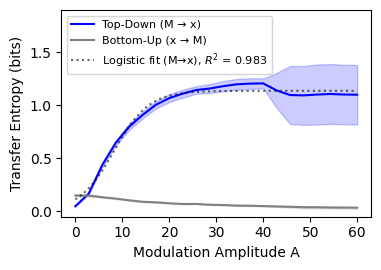


 Clipping summary across A
  A=  0.0 | lower-clipped:         0 ( 0.0000%) | upper-clipped:         0 ( 0.0000%)
  A=  2.9 | lower-clipped:    262962 ( 0.2922%) | upper-clipped:         0 ( 0.0000%)
  A=  5.7 | lower-clipped:    525807 ( 0.5842%) | upper-clipped:         0 ( 0.0000%)
  A=  8.6 | lower-clipped:    833509 ( 0.9261%) | upper-clipped:         0 ( 0.0000%)
  A= 11.4 | lower-clipped:   1063263 ( 1.1814%) | upper-clipped:         0 ( 0.0000%)
  A= 14.3 | lower-clipped:   1405274 ( 1.5614%) | upper-clipped:         0 ( 0.0000%)
  A= 17.1 | lower-clipped:   1657752 ( 1.8419%) | upper-clipped:         0 ( 0.0000%)
  A= 20.0 | lower-clipped:   1939923 ( 2.1555%) | upper-clipped:         0 ( 0.0000%)
  A= 22.9 | lower-clipped:   2245302 ( 2.4948%) | upper-clipped:         0 ( 0.0000%)
  A= 25.7 | lower-clipped:   2565129 ( 2.8501%) | upper-clipped:         0 ( 0.0000%)
  A= 28.6 | lower-clipped:   2899162 ( 3.2213%) | upper-clipped:         0 ( 0.0000%)
  A= 31.4 | lower-clipped:

In [2]:
def simulate_uncoupled_K_modulated(N=N, K0=K0, A=25, omega=2*np.pi/2000,
                                   timesteps=T, discard=discard,
                                   r_min=r_min, r_max=r_max, seed=None):
    rng = np.random.default_rng(seed)
    x = np.full(N, 0.1)
    r = rng.uniform(r_min, r_max, N)

    mean_field, local_series = [], []
    lower_clip_count = 0
    upper_clip_count = 0
    steps_with_any_clip = 0
    T_eff = 0

    for n in range(timesteps):
        K_n = K_sinusoid(n, K0=K0, A=A, omega=omega)
        x_next = logistic_step(x, r, K_n)

        if n >= discard:
            low_hits  = np.sum(x_next <= 0)
            high_hits = np.sum(x_next >= 2 * K0)
            lower_clip_count += int(low_hits)
            upper_clip_count += int(high_hits)
            steps_with_any_clip += int((low_hits + high_hits) > 0)
            T_eff += N

        x = np.clip(x_next, 0, 2 * K0)

        if n >= discard:
            mean_field.append(np.mean(x))
            local_series.append(x[0])

    clip_counts = {
        'lower': lower_clip_count,
        'upper': upper_clip_count,
        'total_points': T_eff,
        'steps_with_any_clip': steps_with_any_clip
    }
    return np.array(mean_field), np.array(local_series), clip_counts

# Sweep over A
A_vals = np.linspace(0, 60, 22)
n_seeds = 10
te_td_all, te_bu_all = [], []

clip_lower_by_A = []
clip_upper_by_A = []
clip_totalpts_by_A = []
clip_steps_any_by_A = []

for A in A_vals:
    td_seeds, bu_seeds = [], []

    total_lower = 0
    total_upper = 0
    total_points = 0
    total_steps_any = 0

    for i in range(n_seeds):
        rng_seed = SEED + i
        M, X, clips = simulate_uncoupled_K_modulated(A=A, seed=rng_seed)

        td = transfer_entropy_lagged(M, X, k=LAG_K_DEFAULT, bins=BINS_DEFAULT)
        bu = transfer_entropy_lagged(X, M, k=LAG_K_DEFAULT, bins=BINS_DEFAULT)
        td_seeds.append(td); bu_seeds.append(bu)

        total_lower     += clips['lower']
        total_upper     += clips['upper']
        total_points    += clips['total_points']
        total_steps_any += clips['steps_with_any_clip']

    te_td_all.append(td_seeds)
    te_bu_all.append(bu_seeds)

    clip_lower_by_A.append(total_lower)
    clip_upper_by_A.append(total_upper)
    clip_totalpts_by_A.append(total_points)
    clip_steps_any_by_A.append(total_steps_any)

clip_lower_by_A      = np.array(clip_lower_by_A)
clip_upper_by_A      = np.array(clip_upper_by_A)
clip_totalpts_by_A   = np.array(clip_totalpts_by_A)
clip_steps_any_by_A  = np.array(clip_steps_any_by_A)

# Mean and 95% CI
td_mean, td_ci = zip(*[mean_ci(vals) for vals in te_td_all])
bu_mean, bu_ci = zip(*[mean_ci(vals) for vals in te_bu_all])
td_mean, td_ci = np.array(td_mean), np.array(td_ci)
bu_mean, bu_ci = np.array(bu_mean), np.array(bu_ci)

# Logistic fit
popt, r2 = fit_logistic_and_r2(A_vals, td_mean)
y_fit = logistic_curve(A_vals, *popt)

# Plot
plt.figure(figsize=(4, 2.8))
plt.plot(A_vals, td_mean, label="Top-Down (M → x)", color='blue')
plt.fill_between(A_vals, td_mean - td_ci, td_mean + td_ci, color='blue', alpha=0.2)
plt.plot(A_vals, bu_mean, label="Bottom-Up (x → M)", color='gray', linestyle='-')
plt.fill_between(A_vals, bu_mean - bu_ci, bu_mean + bu_ci, color='gray', alpha=0.2)
A_fit = np.linspace(0, 60, 200)
plt.plot(A_fit, logistic_curve(A_fit, *popt), color='black', ls=':', alpha=0.6,
         label=f"Logistic fit (M→x), $R^2$ = {r2:.3f}")
plt.xlabel("Modulation Amplitude A",  fontsize=10)
plt.ylabel("Transfer Entropy (bits)",  fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.ylim(-0.05, 1.9)
plt.show()

# clipping summary
print("\n Clipping summary across A")
for A, low, up, tot, steps_any in zip(A_vals, clip_lower_by_A, clip_upper_by_A, clip_totalpts_by_A, clip_steps_any_by_A):
    pct_low = 100.0 * low / tot if tot else 0.0
    pct_up  = 100.0 * up  / tot if tot else 0.0
    print(f"  A={A:5.1f} | lower-clipped: {low:9d} ({pct_low:7.4f}%)"
          f" | upper-clipped: {up:9d} ({pct_up:7.4f}%)")

### Figure 2

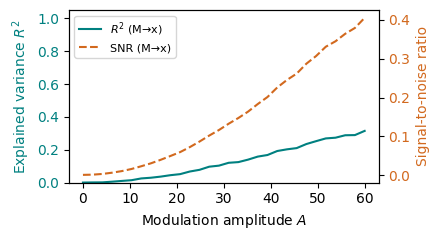

In [3]:
A_values = np.linspace(0, 60, 30)

r2_list  = np.zeros_like(A_values, dtype=float)
snr_list = np.zeros_like(A_values, dtype=float)

for idx, A in enumerate(A_values):
    mod_fn = lambda n, A=A: K_sinusoid(n, K0=K0, A=A)
    X_all, _ = simulate_full_population(mod_fn, N=N, T=T, K0=K0,
                                        r_min=r_min, r_max=r_max, seed=SEED)

    X_all = X_all[:, discard:]
    M_n   = X_all.mean(axis=0)
    xi    = X_all[0, :]

    X_design = M_n.reshape(-1, 1)
    model = LinearRegression().fit(X_design, xi)
    xi_hat = model.predict(X_design)

    # R^2
    r2_list[idx] = r2_score(xi, xi_hat)

    # SNR = var(M) / var(residuals)
    signal_var   = np.var(M_n)
    residual_var = np.var(xi - xi_hat)
    snr_list[idx] = signal_var / residual_var if residual_var > 0 else np.inf

# Plot
fig, ax1 = plt.subplots(figsize=(4.5, 2.5))
color_r2  = 'teal'
color_snr = 'chocolate'
ax1.set_xlabel("Modulation amplitude $A$")
ax1.set_ylabel("Explained variance $R^2$", color=color_r2)
ax1.plot(A_values, r2_list, color=color_r2, label="$R^2$ (M→x)")
ax1.tick_params(axis='y', labelcolor=color_r2)
ax1.set_ylim(0, 1.05)
ax2 = ax1.twinx()
ax2.set_ylabel("Signal-to-noise ratio", color=color_snr)
ax2.plot(A_values, snr_list, color=color_snr, label="SNR (M→x)", ls='--')
ax2.tick_params(axis='y', labelcolor=color_snr)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

### Figure S1

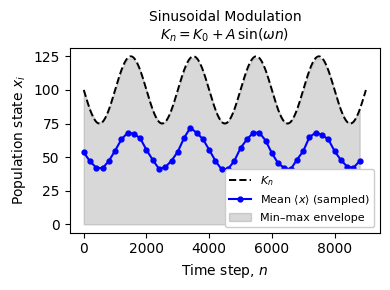

In [4]:
# simulation
A = 25
sample_every = 200

mod_fn = lambda n: K_sinusoid(n, K0=K0, A=A)
X_all, K_t = simulate_full_population(mod_fn, N=N, T=T, K0=K0,
                                      r_min=r_min, r_max=r_max, seed=SEED)

X_all = X_all[:, discard:]
K_t   = K_t[discard:]

T_eff = X_all.shape[1]
sample_indices = np.arange(0, T_eff, sample_every)
X_sampled = X_all[:, sample_indices]
mean_sampled = X_sampled.mean(axis=0)
min_sampled  = X_sampled.min(axis=0)
max_sampled  = X_sampled.max(axis=0)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(np.arange(len(K_t)), K_t, color='black', lw=1.4, ls='--', label=r"$K_n$")
plt.plot(sample_indices, mean_sampled, '-o', ms=3.5, color='blue',
         label='Mean $\langle x\\rangle$ (sampled)')
plt.fill_between(sample_indices, min_sampled, max_sampled,
                 color='gray', alpha=0.3, label='Min–max envelope')
plt.xlabel("Time step, $n$")
plt.ylabel("Population state $x_i$")
plt.title("Sinusoidal Modulation\n$K_n = K_0 + A \\, \sin(\\omega n)$", fontsize=10)
plt.legend(loc='lower right', fontsize=8, facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

### Figure S2

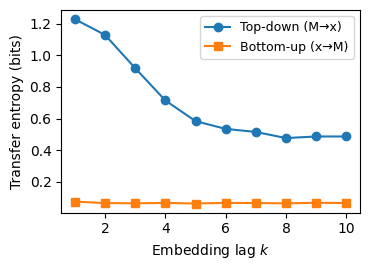

In [5]:
# Simulation
A_val   = 25
lags    = np.arange(1, 11)   # k = 1..10
n_seeds = 10

te_td_seeds = np.zeros((n_seeds, len(lags)))
te_bu_seeds = np.zeros((n_seeds, len(lags)))

mod_fn = lambda n: K_sinusoid(n, K0=K0, A=A_val)

for s in range(n_seeds):
    M, X, _ = simulate_mean_and_unit(mod_fn, N=N, T=T, discard=discard,
                                     K0=K0, r_min=r_min, r_max=r_max, seed=SEED + s)
    for j, k in enumerate(lags):
        te_td_seeds[s, j] = transfer_entropy_lagged(M, X, k=k, bins=BINS_DEFAULT)  # M to x
        te_bu_seeds[s, j] = transfer_entropy_lagged(X, M, k=k, bins=BINS_DEFAULT)  # x to M

td_mean_k = te_td_seeds.mean(axis=0)
bu_mean_k = te_bu_seeds.mean(axis=0)

# Plot
plt.figure(figsize=(3.8, 2.8))
plt.plot(lags, td_mean_k, 'o-', label="Top‑down (M→x)")
plt.plot(lags, bu_mean_k, 's-', label="Bottom‑up (x→M)")
plt.xlabel("Embedding lag $k$")
plt.ylabel("Transfer entropy (bits)")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

### Figure S3

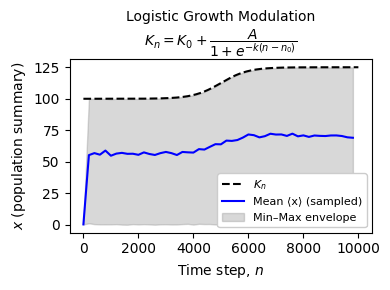

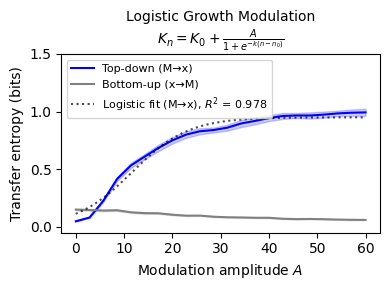

In [7]:
# simulations
n0       = 5000 # midpoint
k_shape  = 0.002 # steepness
A_demo   = 25
sample_every = 200

# Part 1
mod_fn_demo = lambda n: K_logistic(n, K0=K0, A=A_demo, k=k_shape, n0=n0)
X_all, K_t = simulate_full_population(mod_fn_demo, N=N, T=T, K0=K0,
                                      r_min=r_min, r_max=r_max, seed=SEED)

sample_indices = np.arange(0, T, sample_every)
X_sampled      = X_all[:, sample_indices]
mean_sampled   = X_sampled.mean(axis=0)
min_sampled    = X_sampled.min(axis=0)
max_sampled    = X_sampled.max(axis=0)

plt.figure(figsize=(4, 3))
plt.plot(np.arange(T), K_t, color='black', lw=1.5, ls='--', label=r"$K_n$")
plt.plot(sample_indices, mean_sampled, '-', color='blue', label='Mean ⟨x⟩ (sampled)')
plt.fill_between(sample_indices, min_sampled, max_sampled, color='gray', alpha=0.3,
                 label='Min–Max envelope')
plt.xlabel("Time step, $n$")
plt.ylabel("$x$ (population summary)")
plt.title("Logistic Growth Modulation\n$K_n = K_0 + \\dfrac{A}{1 + e^{-k(n - n_0)}}$", fontsize=10)
plt.legend(loc='lower right', fontsize=8, facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

# Part 2
A_vals   = np.linspace(0, 60, 22)
n_reps   = 10
lag_k    = LAG_K_DEFAULT

te_td_all, te_bu_all = [], []
clip_mean_by_A, clip_max_by_A = [], []

for A in A_vals:
    td_reps, bu_reps = [], []
    clip_means_this_A, clip_max_this_A = [], []

    mod_fn_A = lambda n, A=A: K_logistic(n, K0=K0, A=A, k=k_shape, n0=n0)

    for rep in range(n_reps):
        M, X, clip_frac = simulate_mean_and_unit(mod_fn_A, N=N, T=T, discard=discard,
                                                 K0=K0, r_min=r_min, r_max=r_max,
                                                 seed=SEED + rep)
        td_reps.append(transfer_entropy_lagged(M, X, k=lag_k, bins=BINS_DEFAULT))  # M to x
        bu_reps.append(transfer_entropy_lagged(X, M, k=lag_k, bins=BINS_DEFAULT))  # x to M

        clip_means_this_A.append(np.mean(clip_frac))
        clip_max_this_A.append(np.max(clip_frac))

    te_td_all.append(td_reps)
    te_bu_all.append(bu_reps)
    clip_mean_by_A.append(np.mean(clip_means_this_A))
    clip_max_by_A.append(np.mean(clip_max_this_A))

te_td_all      = np.array(te_td_all, dtype=float)
te_bu_all      = np.array(te_bu_all, dtype=float)
clip_mean_by_A = np.array(clip_mean_by_A)
clip_max_by_A  = np.array(clip_max_by_A)

td_mean, td_ci = zip(*[mean_ci(vals) for vals in te_td_all])
bu_mean, bu_ci = zip(*[mean_ci(vals) for vals in te_bu_all])
td_mean, td_ci = np.array(td_mean), np.array(td_ci)
bu_mean, bu_ci = np.array(bu_mean), np.array(bu_ci)

# Fit
popt, R2 = fit_logistic_and_r2(A_vals, td_mean, p0=[max(0.1, td_mean.max()), 0.1, 20.0])

# Plot
plt.figure(figsize=(4, 3))
plt.plot(A_vals, td_mean, label="Top-down (M→x)", color='blue')
plt.fill_between(A_vals, td_mean - td_ci, td_mean + td_ci, color='blue', alpha=0.2)
plt.plot(A_vals, bu_mean, label="Bottom-up (x→M)", color='gray')
plt.fill_between(A_vals, bu_mean - bu_ci, bu_mean + bu_ci, color='gray', alpha=0.2)
A_fit = np.linspace(A_vals.min(), A_vals.max(), 300)
plt.plot(A_fit, logistic_curve(A_fit, *popt), color='black', ls=':', alpha=0.7,
         label=f"Logistic fit (M→x), $R^2$ = {R2:.3f}")
plt.xlabel("Modulation amplitude $A$")
plt.ylabel("Transfer entropy (bits)")
plt.title("Logistic Growth Modulation\n$K_n = K_0 + \\frac{A}{1 + e^{-k(n - n_0)}}$", fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.ylim(-0.05, 1.5)
plt.tight_layout()
plt.show()

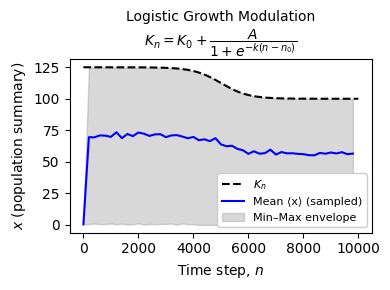

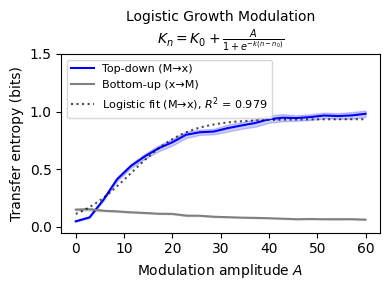

In [8]:
# simulations
n0       = 5000 # midpoint
k_shape  = 0.002 # steepness
A_demo   = 25
sample_every = 200

# Part 1
mod_fn_demo = lambda n: K_invlogistic(n, K0=K0, A=A_demo, k=k_shape, n0=n0)
X_all, K_t = simulate_full_population(mod_fn_demo, N=N, T=T, K0=K0,
                                      r_min=r_min, r_max=r_max, seed=SEED)

sample_indices = np.arange(0, T, sample_every)
X_sampled      = X_all[:, sample_indices]
mean_sampled   = X_sampled.mean(axis=0)
min_sampled    = X_sampled.min(axis=0)
max_sampled    = X_sampled.max(axis=0)

plt.figure(figsize=(4, 3))
plt.plot(np.arange(T), K_t, color='black', lw=1.5, ls='--', label=r"$K_n$")
plt.plot(sample_indices, mean_sampled, '-', color='blue', label='Mean ⟨x⟩ (sampled)')
plt.fill_between(sample_indices, min_sampled, max_sampled, color='gray', alpha=0.3,
                 label='Min–Max envelope')
plt.xlabel("Time step, $n$")
plt.ylabel("$x$ (population summary)")
plt.title("Logistic Growth Modulation\n$K_n = K_0 + \\dfrac{A}{1 + e^{-k(n - n_0)}}$", fontsize=10)
plt.legend(loc='lower right', fontsize=8, facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

# Part 2
A_vals   = np.linspace(0, 60, 22)
n_reps   = 10
lag_k    = LAG_K_DEFAULT

te_td_all, te_bu_all = [], []
clip_mean_by_A, clip_max_by_A = [], []

for A in A_vals:
    td_reps, bu_reps = [], []
    clip_means_this_A, clip_max_this_A = [], []

    mod_fn_A = lambda n, A=A: K_invlogistic(n, K0=K0, A=A, k=k_shape, n0=n0)

    for rep in range(n_reps):
        M, X, clip_frac = simulate_mean_and_unit(mod_fn_A, N=N, T=T, discard=discard,
                                                 K0=K0, r_min=r_min, r_max=r_max,
                                                 seed=SEED + rep)
        td_reps.append(transfer_entropy_lagged(M, X, k=lag_k, bins=BINS_DEFAULT))  # M to x
        bu_reps.append(transfer_entropy_lagged(X, M, k=lag_k, bins=BINS_DEFAULT))  # x to M

        clip_means_this_A.append(np.mean(clip_frac))
        clip_max_this_A.append(np.max(clip_frac))

    te_td_all.append(td_reps)
    te_bu_all.append(bu_reps)
    clip_mean_by_A.append(np.mean(clip_means_this_A))
    clip_max_by_A.append(np.mean(clip_max_this_A))

te_td_all      = np.array(te_td_all, dtype=float)
te_bu_all      = np.array(te_bu_all, dtype=float)
clip_mean_by_A = np.array(clip_mean_by_A)
clip_max_by_A  = np.array(clip_max_by_A)

td_mean, td_ci = zip(*[mean_ci(vals) for vals in te_td_all])
bu_mean, bu_ci = zip(*[mean_ci(vals) for vals in te_bu_all])
td_mean, td_ci = np.array(td_mean), np.array(td_ci)
bu_mean, bu_ci = np.array(bu_mean), np.array(bu_ci)

# Fit
popt, R2 = fit_logistic_and_r2(A_vals, td_mean, p0=[max(0.1, td_mean.max()), 0.1, 20.0])

# Plot
plt.figure(figsize=(4, 3))
plt.plot(A_vals, td_mean, label="Top-down (M→x)", color='blue')
plt.fill_between(A_vals, td_mean - td_ci, td_mean + td_ci, color='blue', alpha=0.2)
plt.plot(A_vals, bu_mean, label="Bottom-up (x→M)", color='gray')
plt.fill_between(A_vals, bu_mean - bu_ci, bu_mean + bu_ci, color='gray', alpha=0.2)
A_fit = np.linspace(A_vals.min(), A_vals.max(), 300)
plt.plot(A_fit, logistic_curve(A_fit, *popt), color='black', ls=':', alpha=0.7,
         label=f"Logistic fit (M→x), $R^2$ = {R2:.3f}")
plt.xlabel("Modulation amplitude $A$")
plt.ylabel("Transfer entropy (bits)")
plt.title("Logistic Growth Modulation\n$K_n = K_0 + \\frac{A}{1 + e^{-k(n - n_0)}}$", fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.ylim(-0.05, 1.5)
plt.tight_layout()
plt.show()

### Figure S4

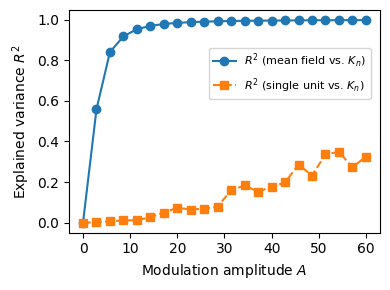

In [9]:
# simulation
A_values = np.linspace(0, 60, 22)
omega = 2 * np.pi / 2000

r2_mean   = np.zeros_like(A_values, dtype=float)
r2_single = np.zeros_like(A_values, dtype=float)

for idx, A in enumerate(A_values):
    mod_fn = lambda n, A=A: K_sinusoid(n, K0=K0, A=A, omega=omega)

    M_series, single_series, _ = simulate_mean_and_unit(
        mod_fn, N=N, T=T, discard=discard, K0=K0,
        r_min=r_min, r_max=r_max, seed=SEED + idx
    )

    K_series = np.array([mod_fn(n) for n in range(T)])[discard:]

    X = K_series.reshape(-1, 1)
    model_mean   = LinearRegression().fit(X, M_series)
    model_single = LinearRegression().fit(X, single_series)

    r2_mean[idx]   = r2_score(M_series,   model_mean.predict(X))
    r2_single[idx] = r2_score(single_series, model_single.predict(X))

# Plot
plt.figure(figsize=(4, 3))
plt.plot(A_values, r2_mean,   'o-',  label=r"$R^2$ (mean field vs. $K_n$)")
plt.plot(A_values, r2_single, 's--', label=r"$R^2$ (single unit vs. $K_n$)")
plt.xlabel("Modulation amplitude $A$")
plt.ylabel(r"Explained variance $R^2$")
plt.legend(loc=(0.45, 0.6), fontsize=8)
plt.tight_layout()
plt.show()

### Figure S5

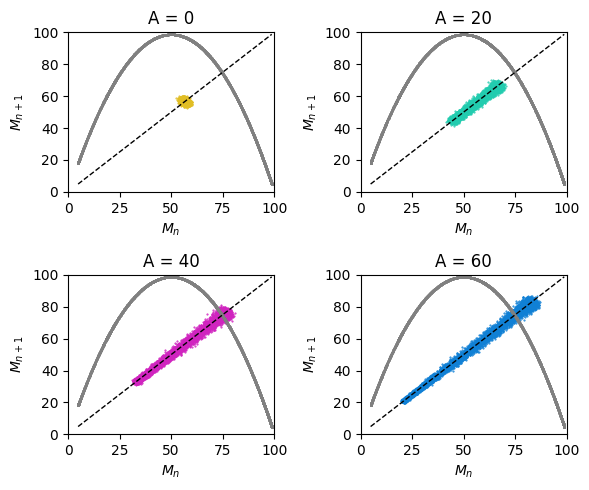

In [10]:
# Panel return maps

A_values = [0, 20, 40, 60]
colors   = ["#E1BE25", "#22CCAF", "#D024BF", "#1080D5"]
omega    = 2 * np.pi / 2000

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.flatten()

for idx, A in enumerate(A_values):
    ax  = axes[idx]
    rng = np.random.default_rng(SEED + idx)
    x   = np.full(N, 0.1)
    r   = rng.uniform(r_min, r_max, N)

    M_n, M_np1 = [], []
    total_steps = 0
    clipped_steps = 0

    for t in range(T):
        K_t  = K_sinusoid(t,   K0=K0, A=A, omega=omega)
        K_t1 = K_sinusoid(t+1, K0=K0, A=A, omega=omega)

        if t >= discard:
            mean_x_t = np.mean(x)
            x_next_for_map = logistic_step(x, r, K_t1)
            mean_x_t1 = np.mean(x_next_for_map)
            M_n.append(mean_x_t)
            M_np1.append(mean_x_t1)

        x_new = logistic_step(x, r, K_t)
        x_new = np.clip(x_new, 0, 2 * K0)
        if t >= discard and np.any(x_new >= 2 * K0):
            clipped_steps += 1
        total_steps += 1
        x = x_new

    ax.scatter(M_n, M_np1, color=colors[idx % len(colors)], s=0.25, alpha=1.0)

    x_single = 1.0
    r_single = 3.95
    x_vals, y_vals = [], []
    for t in range(T):
        x_next = logistic_step(x_single, r_single, K0)
        if t >= discard:
            x_vals.append(x_single)
            y_vals.append(x_next)
        x_single = np.clip(x_next, 0, 2 * K0)
    ax.scatter(x_vals, y_vals, color='gray', s=0.25, alpha=0.8)

    all_vals = M_n + M_np1 + x_vals + y_vals
    vmin, vmax = min(all_vals), max(all_vals)
    ax.plot([vmin, vmax], [vmin, vmax], ls='--', color='black', linewidth=1)

    ax.set_title(f"A = {A}")
    ax.set_xlabel(r"$M_n$")
    ax.set_ylabel(r"$M_{n+1}$")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### Figure S6

A = 0:  0 / 50 significant (empirical p < 0.01)
A = 25: 39 / 50 significant (empirical p < 0.01)


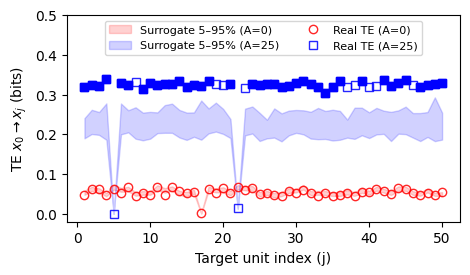

In [11]:
# Params
kbins = BINS_DEFAULT
klag  = LAG_K_DEFAULT
nsurr = 100
delta = 0.01  # one‑sided p‑value threshold
omega = 2 * np.pi / 2000

# helper (return X_all post‑discard)
def simulate_uncoupled(A=0, seed=None):
    """
    Uses shared simulate_full_population with sinusoidal K_n.
    Returns X_all of shape (N, T_eff) after discarding transients.
    """
    mod_fn = lambda n, A=A: K_sinusoid(n, K0=K0, A=A, omega=omega)
    X_all, _ = simulate_full_population(mod_fn, N=N, T=T, K0=K0,
                                        r_min=r_min, r_max=r_max, seed=seed)
    X_all = X_all[:, discard:]
    return X_all

# TE
def transfer_entropy(source, target, k=klag, bins=kbins):
    return transfer_entropy_lagged(source, target, k=k, bins=bins)

# Surrogates (w circular shift)
def circular_shift_surrogate(series, seed=None, min_shift=10):
    rng = np.random.default_rng(seed)
    Tlen = len(series)
    if Tlen <= 1:
        return series.copy()
    if Tlen > 2 * min_shift:
        shift = rng.integers(min_shift, Tlen - min_shift)
    else:
        shift = rng.integers(1, Tlen)
    return np.roll(series, shift)

def surrogate_te_array(source, target, n_surrogates=nsurr, seed=None, k=klag, bins=kbins):
    rng = np.random.default_rng(seed)
    vals = np.empty(n_surrogates, dtype=float)
    for s in range(n_surrogates):
        src_surr = circular_shift_surrogate(source, seed=rng.integers(1 << 30))
        vals[s] = transfer_entropy(src_surr, target, k=k, bins=bins)
    return vals

def empirical_p_value(te_obs, te_surr):
    te_surr = np.asarray(te_surr)
    return (1 + np.sum(te_surr >= te_obs)) / (1 + len(te_surr))

# TE x0 to xj for j=1..max_targets
def compute_te_profile(A, max_targets, n_surrogates=nsurr, seed=None, k=klag, bins=kbins):
    X_all = simulate_uncoupled(A=A, seed=seed)  # (N, T_eff)
    x0 = X_all[0]
    real_te, pvals, surr_p05, surr_p95 = [], [], [], []
    for j in range(1, max_targets + 1):
        xj = X_all[j]
        te_obs = transfer_entropy(x0, xj, k=k, bins=bins)
        te_surr = surrogate_te_array(
            x0, xj, n_surrogates=n_surrogates,
            seed=None if seed is None else seed + j, k=k, bins=bins
        )
        real_te.append(te_obs)
        pvals.append(empirical_p_value(te_obs, te_surr))
        surr_p05.append(np.percentile(te_surr, 5))
        surr_p95.append(np.percentile(te_surr, 95))
    return (np.array(real_te),
            np.array(pvals),
            np.array(surr_p05),
            np.array(surr_p95))

# Run for A=0 and A=25
max_targets = 50
real_te_0,  p_0,  s05_0,  s95_0  = compute_te_profile(A=0,  max_targets=max_targets, n_surrogates=nsurr, seed=SEED)
real_te_25, p_25, s05_25, s95_25 = compute_te_profile(A=25, max_targets=max_targets, n_surrogates=nsurr, seed=SEED)

x_vals = np.arange(1, max_targets + 1)
sig_0  = p_0  < delta
sig_25 = p_25 < delta
print(f"A = 0:  {np.sum(sig_0)} / {len(sig_0)} significant (empirical p < {delta})")
print(f"A = 25: {np.sum(sig_25)} / {len(sig_25)} significant (empirical p < {delta})")

# Plot
plt.figure(figsize=(4.8, 2.8))
plt.fill_between(x_vals, s05_0,  s95_0,  color='red',  alpha=0.18, label='Surrogate 5–95% (A=0)')
plt.fill_between(x_vals, s05_25, s95_25, color='blue', alpha=0.18, label='Surrogate 5–95% (A=25)')
plt.plot(x_vals, real_te_0,  'o', mfc='none', color='red',  label='Real TE (A=0)',  alpha=0.85)
plt.plot(x_vals, real_te_25, 's', mfc='none', color='blue', label='Real TE (A=25)', alpha=0.85)
plt.plot(x_vals[sig_0],  real_te_0[sig_0],  'o', color='red',  lw=0)
plt.plot(x_vals[sig_25], real_te_25[sig_25], 's', color='blue', lw=0)
plt.xlabel("Target unit index (j)", fontsize=10)
plt.ylabel(r"TE $x_0 \rightarrow x_j$ (bits)", fontsize=10)
plt.legend(loc="upper center", ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(-0.02, 0.5)
plt.show()